In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motion classification with time series using deep learning (copy)

> Classify between chaotic, rotational and librational motion using the evolution of the coordinates x and y in the Poincare map

In [ ]:
# parameters cell. Put here everything that could be neededif
# this notebook was called from outside, as an script
use_wandb = False # Whether to use or not wandb for experiment tracking
wandb_group = None # Whether to group this run in a wandb group
resampling_period = None # * Natural number. Set to None if no resampling is desired

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install git+https://github.com/fastai/fastcore.git@master -q
    !pip install git+https://github.com/fastai/fastai2.git@master -q
    !pip install git+https://github.com/timeseriesAI/timeseriesAI.git@master -q
    !pip install wandb -q

In [ ]:
from fastai2.basics import *
from mlchaos.all import *
from tsai.all import *
import wandb
from fastai2.callback.wandb import *

In [ ]:
base_path = Path.home()

In [ ]:
if not use_wandb:
    os.environ['WANDB_MODE'] = 'dryrun' # run offline
    wandb.init(anonymous='allow')
else:
    os.environ['WANDB_MODE'] = 'run' # run offline
    wandb.init(project='mlchaos', group=wandb_group)

## Loading and splitting the data into traiing and validation

The data must be loaded as a `TSDataChaos` object, created from a pair (or a sequence of pairs) of files:
1. The first file of the pair contains the data of the Poincare map
2. The second file of the pair contains the index of the motion (0.0, 1.0 or 2.0)

In [ ]:
ds_path = base_path/'data/third_dataset'
fnames = [
    (ds_path/'eps_1e-2/Poincare200pt.plt', ds_path/'eps_1e-2/index200pt.plt'), 
    (ds_path/'eps_3e-2/Poincare200pt.plt', ds_path/'eps_3e-2/index200pt.plt'), 
    (ds_path/'eps_5e-2/Poincare200pt.plt', ds_path/'eps_5e-2/index200pt.plt')
]
wandb.config.fnames = fnames
data = TSDataChaos.from_poincare_and_index_files(fnames)
data

TSDataChaos:
 Datasets names (concatenated): ['eps_1e-2', 'eps_3e-2', 'eps_5e-2']
 Filenames:                     [(Path('/home/user/data/third_dataset/eps_1e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_1e-2/index200pt.plt')), (Path('/home/user/data/third_dataset/eps_3e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_3e-2/index200pt.plt')), (Path('/home/user/data/third_dataset/eps_5e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_5e-2/index200pt.plt'))]
 Data shape: (30603, 2, 201)
 Targets shape: (30603,)
 Nb Samples: 30603
 Nb Channels:           2
 Sequence Length: 201

Check the distribution of classes in the dataset

In [ ]:
np.unique(data.y, return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([ 1562,  7438, 12768,  8835]))

The class -1 represents uncertainty in the FLI-based classication. If desired, we can remove that class from the dataset, by changing the flag `add_uncertainty_class` in the cell below. 

In [ ]:
wandb.config.add_uncertainty_class = False

In [ ]:
if not wandb.config.add_uncertainty_class:
    data.x = data.x[data.y != -1]
    data.y = data.y[data.y != -1]
data

TSDataChaos:
 Datasets names (concatenated): ['eps_1e-2', 'eps_3e-2', 'eps_5e-2']
 Filenames:                     [(Path('/home/user/data/third_dataset/eps_1e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_1e-2/index200pt.plt')), (Path('/home/user/data/third_dataset/eps_3e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_3e-2/index200pt.plt')), (Path('/home/user/data/third_dataset/eps_5e-2/Poincare200pt.plt'), Path('/home/user/data/third_dataset/eps_5e-2/index200pt.plt'))]
 Data shape: (29041, 2, 201)
 Targets shape: (29041,)
 Nb Samples: 29041
 Nb Channels:           2
 Sequence Length: 201

The data can be resampled to a lower frequency if desired. The reason why this is interesting is because being able to produce an accurate classification without the need of many data points per time series makes this procedure applicable to observational data. As an example, choosing `resampling_period` equals to 2 means that the time series will be resampled in a way that we take one point every 2 points of the original data.  

In [ ]:
wandb.config.resampling_period = resampling_period

In [ ]:
if wandb.config.resampling_period is not None:
    data.x = data.x[:,:,::wandb.config.resampling_period]
    print(data)

By default we use 80% random items from the data as training and 20% as validation

In [ ]:
splits = RandomSplitter()(range_of(data.get_items()))
splits

((#23233) [20316,3525,3661,28797,26562,12116,22724,17210,14991,5208...],
 (#5808) [11388,20024,7001,2256,18640,15530,9027,4971,4879,20209...])

##  Creating a `Datasets` object

In [ ]:
lbl_dict = dict([
    ('-1.0', 'uncertain'),
    ('0.0', 'chaotic'),   
    ('1.0', 'rotational'),   
    ('2.0', 'librational')]
)

In [ ]:
tfms = [None, # x transforms
        [Categorize()]] # y transforms

In [ ]:
%%time
ds = TSDatasets(X=data.x, y=data.y, tfms=tfms, splits=splits, inplace=True)

CPU times: user 5.04 s, sys: 166 ms, total: 5.21 s
Wall time: 5.16 s


Show one element of the dataset. By default, the `show` method will display the item as a Poincare map.

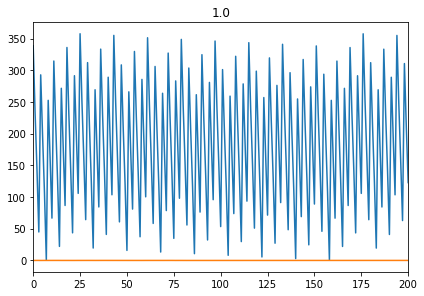

In [ ]:
ax = show_at(ds, 1003)

It can be useful to visualize the motions with he same y limits. We take them from the training set

In [ ]:
ylim = [data.x[:, 1].min(), data.x[:, 1].max()]
ylim

[-0.7248967745980109, 1.72489677459802]

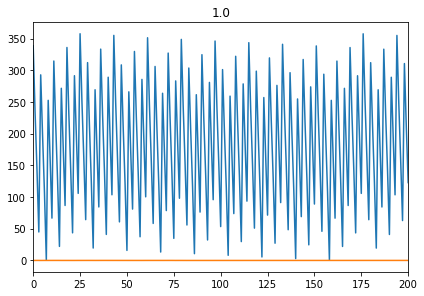

In [ ]:
ax = show_at(ds, 1003)

## Creating a `Dataloaders` object using the `Datasets` object

In [ ]:
bs = 256                            
# Normalize at batch time
tfm_norm = TSStandardize()
batch_tfms = [tfm_norm]

dls = TSDataLoaders.from_dsets(ds.train, ds.valid, vs=[bs,bs*2], 
                               batch_tfms=batch_tfms, num_workers=0)

CPU times: user 1.51 s, sys: 142 ms, total: 1.65 s
Wall time: 1.45 s


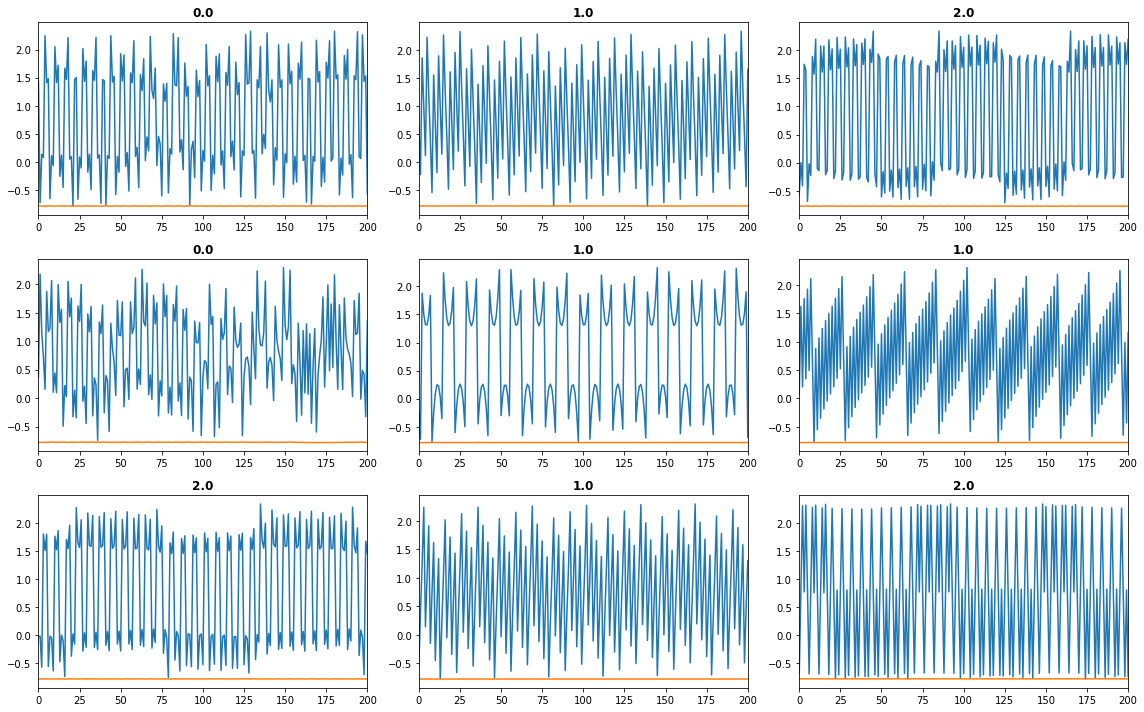

In [ ]:
%%time
dls.show_batch(max_n=9, return_fig=False)

In [ ]:
xb, yb = dls.one_batch()
print(xb[0].mean(axis=1), xb[0].std(axis=1))

TSTensor(len:2) TSTensor(len:2)


## Training a model 

In [ ]:
model = InceptionTime(dls.vars, dls.c) # model
model

InceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(2, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(2, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(2, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, 
                loss_func=loss_func, metrics=accuracy)

# print(learn.summary())

(0.07585775852203369, 0.002511886414140463)

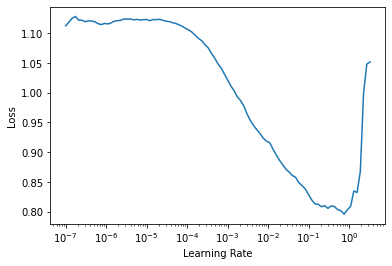

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

epoch,train_loss,valid_loss,accuracy,time
0,0.365207,0.436628,0.927169,00:17
1,0.364163,0.350711,0.973485,00:16
2,0.347464,0.637327,0.820420,00:16
3,0.335861,0.325227,0.981921,00:16
4,0.326648,0.349647,0.968320,00:16
5,0.321846,0.314861,0.991563,00:16
6,0.312796,0.311971,0.991391,00:16
7,0.304880,0.302804,0.994835,00:16
8,0.300538,0.301343,0.995523,00:16
9,0.300305,0.300859,0.995868,00:16


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


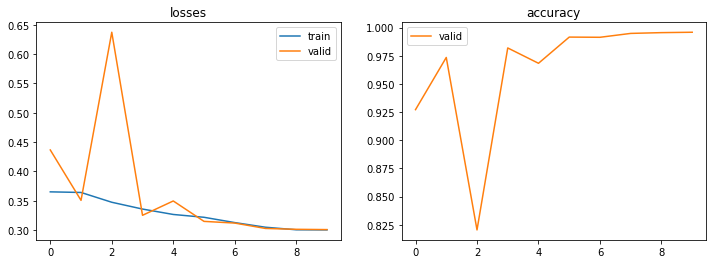

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-3, cbs=WandbCallback(log_preds=False))
learn.recorder.plot_metrics()

## Showing results

### Results for random items in the validation set 

In [ ]:
learn.show_results(max_n=9)

### Showing the confusion matrix

In [ ]:
interp = ClassificationInterpretationAugmented.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

### Smallest errors

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=False, ylim=ylim)

### Largest errores

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=True, ylim=ylim)

## Types of errors

It is also interesting to display separately errors of different type. There are a number of `c*(c-1)` possible type of errors, where `c` is the number of classes in the data

In [ ]:
# predicted = 'rotational'
# actual = 'librational'
# n_errors = interp.confusion_matrix()[interp.vocab.o2i[predicted], 
#                                      interp.vocab.o2i[actual]]
# interp.plot_top_losses(k=min(n_errors, 9), figsize=(15, 15), 
#                        largest=True, ylim=ylim, 
#                        predicted='rotational', 
#                        actual='librational')

## Inference on a new test set

Now let's see how the trained behaves with a completely unseen set of data. First we have to load the Poincare maps that comprise the test set

Compute the predicted labels using the library `fastinference`. It is faster than the original `fastai` implementation.

In [ ]:
old_get_preds = learn.get_preds
from fastinference.inference import *

In [ ]:
test_path = base_path/'data/test/eps_equals0_02_pert_pend_model_2/Poincare.plt'
test_poinc_maps = load_poincare_maps(test_path)
test_poinc_maps.shape

Create a dataloader from the test items previously loaded. This will apply all the transformations used in our training and validation set (e.g. normalization) to the test data

In [ ]:
test_dl = learn.dls.test_dl(test_poinc_maps)
test_dl.n

In [ ]:
lbls, _ = learn.get_preds(dl=test_dl)
lbls.__len__()

Show the FLI plot to get a sense of the quality of the predictions

In [ ]:
fli = show_fli_plot(test_dl.items, 
                    lbls, 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta', 
                        uncertain='green'))